In [1]:
!mkdir input\data
!mkdir outputs 

mkdir: cannot create directory ‘inputdata’: File exists
mkdir: cannot create directory ‘outputs’: File exists


In [2]:
!pip install torch==1.4.0 torchvision==0.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
import torch.nn as nn
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')

In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            # nz will be the input to the first convolution
            nn.ConvTranspose2d(
                nz, 512, kernel_size=4, 
                stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                512, 256, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                256, 128, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                128, 64, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(
                64, 3, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(
                3, 64, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                64, 128, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                128, 256, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                256, 512, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(
                512, 1, kernel_size=4, 
                stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
def label_real(size):
    """
    Fucntion to create real labels (ones)
    :param size: batch size
    :return real label vector
    """
    data = torch.ones(size, 1)
    return data.to(device)

    
def label_fake(size):
    """
    Fucntion to create fake labels (zeros)
    :param size: batch size
    :returns fake label vector
    """
    data = torch.zeros(size, 1)
    return data.to(device)

In [8]:
def create_noise(sample_size, nz):
    """
    Fucntion to create noise
    :param sample_size: fixed sample size or batch size
    :param nz: latent vector size
    :returns random noise vector
    """
    return torch.randn(sample_size, nz, 1, 1).to(device)

In [9]:
def save_generator_image(image, path):
    """
    Function to save torch image batches
    :param image: image tensor batch
    :param path: path name to save image
    """
    save_image(image, path, normalize=True)

In [10]:
def weights_init(m):
    """
    This function initializes the model weights randomly from a 
    Normal distribution. This follows the specification from the DCGAN paper.
    https://arxiv.org/pdf/1511.06434.pdf
    Source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [11]:
# learning parameters / configurations according to paper
image_size = 64 # we need to resize image to 64x64
batch_size = 128
nz = 100 # latent vector size
beta1 = 0.5 # beta1 value for Adam optimizer
lr = 0.0002 # learning rate according to paper
sample_size = 64 # fixed sample size
epochs = 25 # number of epoch to train

In [12]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), 
    (0.5, 0.5, 0.5)),
])

In [13]:
# prepare the data
train_data = datasets.CIFAR10(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [14]:
# initialize models
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device) 

In [15]:
# initialize weights
generator.apply(weights_init)
discriminator.apply(weights_init)

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
 

In [16]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optim_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# loss function
criterion = nn.BCELoss()

In [17]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch

In [18]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    # get the real label vector
    real_label = label_real(b_size)
    # get the fake label vector
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    # get the outputs by doing real data forward pass
    output_real = discriminator(data_real).view(-1)
    loss_real = criterion(output_real, real_label)
    # get the outputs by doing fake data forward pass
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    # compute gradients of real loss 
    loss_real.backward()
    # compute gradients of fake loss
    loss_fake.backward()
    # update discriminator parameters
    optimizer.step()
    return loss_real + loss_fake

In [19]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    # get the real label vector
    real_label = label_real(b_size)
    optimizer.zero_grad()
    # output by doing a forward pass of the fake data through discriminator
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    # compute gradients of loss
    loss.backward()
    # update generator parameters
    optimizer.step()
    return loss 

In [20]:
# create the noise vector
noise = create_noise(sample_size, nz)

In [21]:
generator.train()
discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [24]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # forward pass through generator to create fake data
        data_fake = generator(create_noise(b_size, nz)).detach()
        data_real = image
        loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        loss_g += train_generator(optim_g, data_fake)
    # final forward pass through generator to create fake data...
    # ...after training for current epoch
    generated_img = generator(noise).cpu().detach()
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"./outputs/gen_img{epoch}.png")
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

391it [01:38,  3.99it/s]


Epoch 1 of 25
Generator loss: 4.56661320, Discriminator loss: 0.60977119


391it [01:35,  4.08it/s]


Epoch 2 of 25
Generator loss: 3.80896735, Discriminator loss: 0.60865068


391it [01:35,  4.09it/s]


Epoch 3 of 25
Generator loss: 3.46320748, Discriminator loss: 0.65073305


391it [01:35,  4.09it/s]


Epoch 4 of 25
Generator loss: 3.05981421, Discriminator loss: 0.72997606


391it [01:35,  4.10it/s]


Epoch 5 of 25
Generator loss: 2.87462735, Discriminator loss: 0.75523925


391it [01:35,  4.10it/s]


Epoch 6 of 25
Generator loss: 2.86772084, Discriminator loss: 0.73431206


391it [01:35,  4.10it/s]


Epoch 7 of 25
Generator loss: 3.02355051, Discriminator loss: 0.74504787


391it [01:35,  4.10it/s]


Epoch 8 of 25
Generator loss: 3.13453126, Discriminator loss: 0.68036062


391it [01:35,  4.10it/s]


Epoch 9 of 25
Generator loss: 2.99489093, Discriminator loss: 0.66491759


391it [01:35,  4.10it/s]


Epoch 10 of 25
Generator loss: 3.25395465, Discriminator loss: 0.62271267


391it [01:35,  4.09it/s]


Epoch 11 of 25
Generator loss: 3.24586058, Discriminator loss: 0.60328138


391it [01:35,  4.10it/s]


Epoch 12 of 25
Generator loss: 3.05953789, Discriminator loss: 0.62864947


391it [01:35,  4.10it/s]


Epoch 13 of 25
Generator loss: 3.30888629, Discriminator loss: 0.65408081


391it [01:35,  4.08it/s]


Epoch 14 of 25
Generator loss: 2.92199969, Discriminator loss: 0.74070913


391it [01:35,  4.10it/s]


Epoch 15 of 25
Generator loss: 3.14001703, Discriminator loss: 0.63313049


391it [01:35,  4.10it/s]


Epoch 16 of 25
Generator loss: 2.49961925, Discriminator loss: 0.76571351


391it [01:35,  4.10it/s]


Epoch 17 of 25
Generator loss: 4.03389168, Discriminator loss: 0.42159113


391it [01:35,  4.11it/s]


Epoch 18 of 25
Generator loss: 3.37758350, Discriminator loss: 0.56630307


391it [01:35,  4.10it/s]


Epoch 19 of 25
Generator loss: 2.84826016, Discriminator loss: 0.75126731


391it [01:35,  4.10it/s]


Epoch 20 of 25
Generator loss: 2.88351655, Discriminator loss: 0.67100447


391it [01:35,  4.10it/s]


Epoch 21 of 25
Generator loss: 3.28382349, Discriminator loss: 0.55260170


391it [01:35,  4.10it/s]


Epoch 22 of 25
Generator loss: 3.00049162, Discriminator loss: 0.73154950


391it [01:35,  4.10it/s]


Epoch 23 of 25
Generator loss: 3.22338700, Discriminator loss: 0.56471515


391it [01:35,  4.10it/s]


Epoch 24 of 25
Generator loss: 3.78870416, Discriminator loss: 0.45268580


391it [01:35,  4.11it/s]


Epoch 25 of 25
Generator loss: 2.79375386, Discriminator loss: 0.73263693


In [26]:
print('DONE TRAINING')
# save the model weights to disk
torch.save(generator.state_dict(), './outputs/generator.pth')

DONE TRAINING


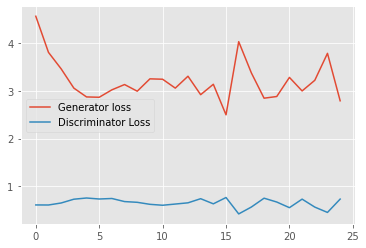

In [36]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot([x.detach().cpu().numpy() for x in losses_g], label='Generator loss')
plt.plot([x.detach().cpu().numpy() for x in losses_d], label='Discriminator Loss')
plt.legend()
plt.savefig('./outputs/loss.png')
plt.show()